In [1]:
ENV["PYTHONPATH"] = "/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
D = 2;
using HDF5, PyPlot
using DelimitedFiles, PyPlot, LinearAlgebra, JLD2, PyCall, StaticArrays, Statistics
using Crystalline, Brillouin, MPBUtils, SymmetryBases
using Crystalline: TEST_αβγs, TEST_αβγ, dot, norm
using Crystalline: normscale, matching_littlegroups
using Crystalline: AbstractFourierLattice
topology_paper_dir = "../../TopologyPaper/"
include(topology_paper_dir * "get-freqs-symeigs.jl")
include(topology_paper_dir * "symeigs-from-io.jl");
include("../../Topology_ML/Phc_ML/fft.jl")
include("../get_uc_coefs.jl");
np = pyimport("numpy");

In [2]:
# Symmetry vectors corresponding to the eight classes
ns = [[0, 1, 0, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1], 
[0, 1, 0, 1, 1, 0, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1], 
[1, 0, 1, 0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1]];

In [3]:
obstructed_idxs = [2, 3, 5, 8]; # Indices corresponding to obstructed atomic limits
topological_idxs = [1, 4, 6, 7]; # Indices corresponding to stably topological bands

In [4]:
two_tone_dir = "./inverse_design_two_tone/dispersion/logs/"
f = jldopen(two_tone_dir * "sg2-tm-log.jld2")
logsv = f["logsv"];

In [5]:
dispersionsv = Matrix{Float64}[];

In [6]:
kpts = Vector{Float64}()
for (id, logstr) in enumerate(logsv)
    ((id % 100) == 0) && (println(id); flush(stdout))
    dispersion_str = logs_to_dispersion(logstr, "tm");
    dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
    dispersion = sort(dispersion, dims=2)
    push!(dispersionsv, dispersion)
    kpts = readdlm(IOBuffer(dispersion_str), ',')[:, 2:4];
    (id == 1) && global kpts = kpts
end

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [7]:
absolute_gaps = [];
relative_gaps = [];

In [8]:
for dispersion in dispersionsv
    absolute_gap = minimum(dispersion[:, 2]) - maximum(dispersion[: , 1]) 
    relative_gap = minimum(dispersion[:, 2] - dispersion[:, 1])
    push!(absolute_gaps, absolute_gap)
    push!(relative_gaps, relative_gap)
end

In [9]:
best_absolute_gap = maximum(absolute_gaps)
best_relative_gap = maximum(relative_gaps)
println("Best absolute gap: $(best_absolute_gap)\nBest relative gap: $(best_relative_gap)");

Best absolute gap: -0.0038489999999999913
Best relative gap: 0.0034369999999999956


In [10]:
println("Best k-wise gap in inverse designed dataset corresponds to index: ", argmax(relative_gaps))

Best k-wise gap in inverse designed dataset corresponds to index: 93


In [11]:
A_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0.5, 0] .- collect(row)) for row in eachrow(kpts)])
Gamma_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0, 0] .- collect(row)) for row in eachrow(kpts)])
B_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0, 0] .- collect(row)) for row in eachrow(kpts)]);
Y_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0.5, 0] .- collect(row)) for row in eachrow(kpts)]);

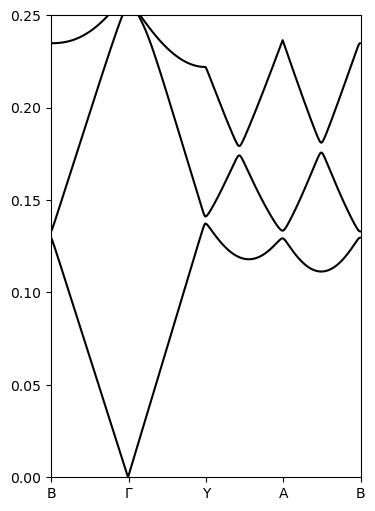

In [12]:
figure(figsize=(4, 6))
dispersion = dispersionsv[93]
plot(dispersion[:, 1:3], color="black");
ylim(0, 0.25)
xlim(0, 404);
xticks([Gamma_point_idxs..., A_point_idxs..., B_point_idxs..., Y_point_idxs...], [repeat(["Γ"], length(Gamma_point_idxs))...,
        repeat(["A"], length(A_point_idxs))..., repeat(["B"], length(B_point_idxs))..., repeat(["Y"], length(Y_point_idxs))...])
;

In [13]:
contrast_dir = "./inverse_design_two_tone/change_contrast/dispersion/logs/"
f = jldopen(contrast_dir * "sg2-contrast_idx6-tm-log.jld2")
logsv = f["logsv"];

In [14]:
dispersionsv = Matrix{Float64}[];

In [15]:
for (id, logstr) in enumerate(logsv)
    dispersion_str = logs_to_dispersion(logstr, "tm");
    dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
    dispersion = sort(dispersion, dims=2)
    push!(dispersionsv, dispersion)
    kpts = readdlm(IOBuffer(dispersion_str), ',')[:, 2:4];
end

In [16]:
absolute_gaps = [];
relative_gaps = [];
for dispersion in dispersionsv
    absolute_gap = minimum(dispersion[:, 2]) - maximum(dispersion[: , 1]) 
    relative_gap = minimum(dispersion[:, 2] - dispersion[:, 1])
    push!(absolute_gaps, absolute_gap)
    push!(relative_gaps, relative_gap)
end

In [17]:
best_absolute_gap = maximum(absolute_gaps)
best_relative_gap = maximum(relative_gaps)
println("Best absolute gap: $(best_absolute_gap)\nBest relative gap: $(best_relative_gap)");

Best absolute gap: 0.04659200000000002
Best relative gap: 0.05048399999999997


In [18]:
println("Best absolute gap corresponds to inverse designed photonic crystal with index: ", argmax(absolute_gaps))

Best absolute gap corresponds to inverse designed photonic crystal with index: 395


In [19]:
println("Best k-wise gap corresponds to inverse designed photonic crystal with index: ", argmax(relative_gaps))

Best k-wise gap corresponds to inverse designed photonic crystal with index: 395


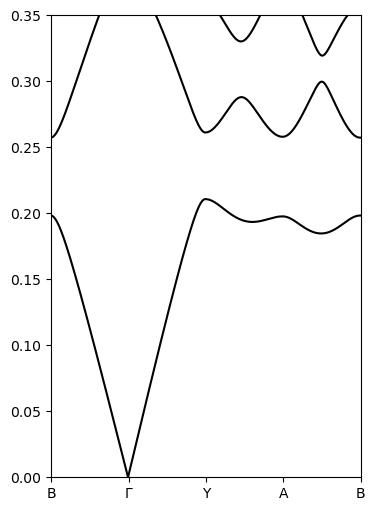

In [20]:
figure(figsize=(4, 6))
dispersion = dispersionsv[395]
plot(dispersion[:, 1:3], color="black");
ylim(0, 0.35)
xlim(0, 404);
xticks([Gamma_point_idxs..., A_point_idxs..., B_point_idxs..., Y_point_idxs...], [repeat(["Γ"], length(Gamma_point_idxs))...,
        repeat(["A"], length(A_point_idxs))..., repeat(["B"], length(B_point_idxs))..., repeat(["Y"], length(Y_point_idxs))...])
;

In [21]:
contrast_idx = 6
contrast_dir = "./inverse_design_two_tone/change_contrast/output/sg2/tm/contrast$(contrast_idx)/"
filename = "sg2-tm-contrast$(contrast_idx).jld2";
loaded_data = load(contrast_dir * filename);

In [22]:
println("Symmetry class for the lowest band: ", findfirst(x-> x==loaded_data["summariesv"][395][1].n, ns))

Symmetry class for the lowest band: 2


In [23]:
loaded_data["summariesv"][395][1]

1-band BandSummary:
 bands:      1:1
 n:          Y₂, B₁, A₂, Γ₁
 topology:   trivial

# Band structures of inverse designed smooth lattices: 

We choose structure 395, since it has the best gap in the high contrast regime. Below, we check that it belongs to the correct symmetry class at all points of our inverse design process

In [24]:
# Band symmetries for the smooth lattice
dir = "./inverse_design_smooth/output/sg2/tm/";
filename = "sg2-tm.jld2";
loaded_data = load(dir * filename);
loaded_data["summariesv"][395][1].n == ns[2]

true

In [25]:
# Band symmetries for the two-tone lattice
dir = "./inverse_design_two_tone/output/sg2/tm/";
filename = "sg2-tm.jld2";
filename = "sg2-tm.jld2";
loaded_data = load(dir * filename);
loaded_data["summariesv"][395][1].n == ns[2]

true

In [26]:
# Band symmetries for high contrast two-tone lattice
for contrast_idx in 1:6
    contrast_dir = "./inverse_design_two_tone/change_contrast/output/sg2/tm/contrast$(contrast_idx)/"
    filename = "sg2-tm-contrast$(contrast_idx).jld2";
    loaded_data = load(contrast_dir * filename);
    println(loaded_data["summariesv"][395][1].n == ns[2])
end

true
true
true
true
true
true


In [27]:
# Check if this sample passed our inverse design filter
dir = "inverse_design_two_tone/";
expect_to_be_good = []
for n in range(0, 7)
    filename = "two_tone_scores-class$(n).h5"
    f = h5open(dir * filename, "r")
    which_good = findall(x-> x == n, np.argmax(f["two_tone_classifications"][], axis=0))
    push!(expect_to_be_good, which_good)
end

In [28]:
395 in expect_to_be_good[2] .+ 250

true

In [29]:
dispersionsv_smooth = Matrix{Float64}[];
kpts_smooth = Vector{Float64}();
dispersionsv_two_tone = Matrix{Float64}[];
dispersionsv_high_contrast = Matrix{Float64}[];

In [30]:
smooth_dir = "./inverse_design_smooth/dispersion/logs/"
two_tone_dir = "./inverse_design_two_tone/dispersion/logs/"
contrast_dir = "./inverse_design_two_tone/change_contrast/dispersion/logs/"

f = jldopen(smooth_dir * "sg2-tm-log.jld2")
logsv_smooth = f["logsv"];

f = jldopen(two_tone_dir * "sg2-tm-log.jld2")
logsv_two_tone = f["logsv"];

f = jldopen(contrast_dir * "sg2-contrast_idx6-tm-log.jld2")
logsv_high_contrast = f["logsv"];

In [31]:
for (id, logstr) in enumerate(logsv_smooth)
    dispersion_str = logs_to_dispersion(logstr, "tm");
    dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
    dispersion = sort(dispersion, dims=2)
    push!(dispersionsv_smooth, dispersion)
    kpts_smooth = readdlm(IOBuffer(dispersion_str), ',')[:, 2:4];
    (id == 1) && global kpts_smooth = kpts
end

In [32]:
for (id, logstr) in enumerate(logsv_two_tone)
    dispersion_str = logs_to_dispersion(logstr, "tm");
    dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
    dispersion = sort(dispersion, dims=2)
    push!(dispersionsv_two_tone, dispersion)
end

In [33]:
for (id, logstr) in enumerate(logsv_high_contrast)
    dispersion_str = logs_to_dispersion(logstr, "tm");
    dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
    dispersion = sort(dispersion, dims=2)
    push!(dispersionsv_high_contrast, dispersion)
end

In [34]:
A_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0.5, 0] .- collect(row)) for row in eachrow(kpts_smooth)])
Gamma_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0, 0] .- collect(row)) for row in eachrow(kpts_smooth)])
B_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0, 0] .- collect(row)) for row in eachrow(kpts_smooth)]);
Y_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0.5, 0] .- collect(row)) for row in eachrow(kpts_smooth)]);

### Below, we show how we open up the gap by going to higher contrast

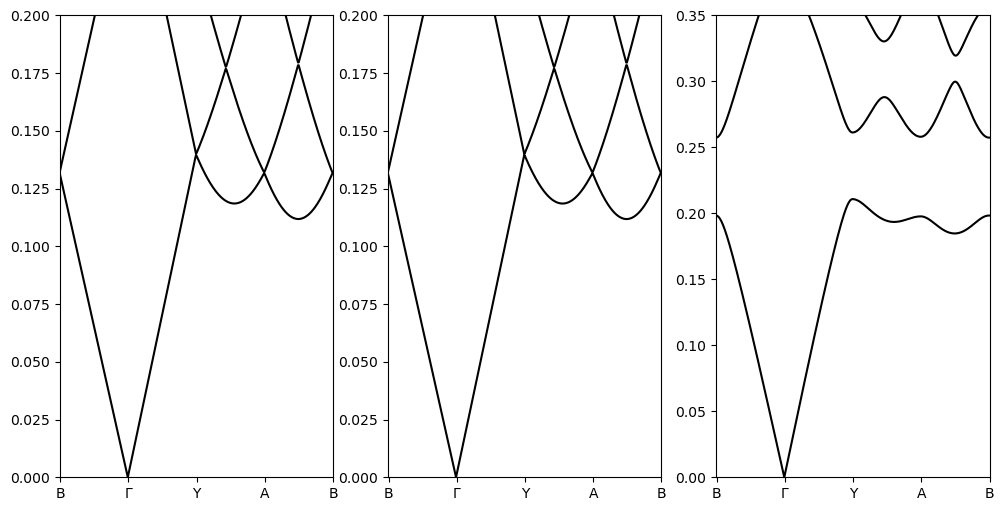

In [35]:
figure(figsize=(12, 6))
idx = 395
for (n, dispersionsv) in enumerate([dispersionsv_smooth, dispersionsv_two_tone, dispersionsv_high_contrast])
    subplot(1, 3, n)
    dispersion = dispersionsv[395]
    plot(dispersion[:, 1:3], color="black");
    ylim(0, 0.35)
    if n < 3
        ylim(0, 0.2)
    end
    xlim(0, 404);
    xticks([Gamma_point_idxs..., A_point_idxs..., B_point_idxs..., Y_point_idxs...], [repeat(["Γ"], length(Gamma_point_idxs))...,
            repeat(["A"], length(A_point_idxs))..., repeat(["B"], length(B_point_idxs))..., repeat(["Y"], length(Y_point_idxs))...])
    ;
end
#savefig("./figures/inverse_design_bands_from_KAN.pdf")

In [36]:
smooth_dir = "./inverse_design_smooth/dispersion/output/sg2/tm/"
two_tone_dir = "./inverse_design_two_tone/dispersion/output/sg2/tm/"
contrast_dir = "./inverse_design_two_tone/change_contrast/dispersion/output/sg2/tm/contrast6/";

In [37]:
filename = "dim2-sg2-395-res64-tm-epsilon.h5"
f = h5open(smooth_dir * filename, "r")
epsilon_smooth = f["data"][];
close(f)
filename = "dim2-sg2-395-res64-tm-epsilon.h5"
f = h5open(two_tone_dir * filename, "r")
epsilon_two_tone = f["data"][];
close(f)

filename = "dim2-sg2-$(20000*5+ 395)-res64-tm-epsilon.h5"
f = h5open(contrast_dir * filename, "r")
epsilon_high_contrast = f["data"][];
close(f)

In [38]:
filename = "dim2-sg2-395-res64-tm-epsilon.h5"
f = h5open(smooth_dir * filename, "r")
lattice_vectors = f["lattice vectors"][];

In [39]:
N = 64
xs = ys = np.linspace(-0.5, 0.5, N, endpoint=false)
xs = np.repeat(np.reshape(xs, (1, N)), N, axis=0);
ys = np.repeat(np.reshape(ys, (N, 1)), N, axis=1);

### Below, we show how the smooth $\rightarrow$ two-tone transition looks like in real space

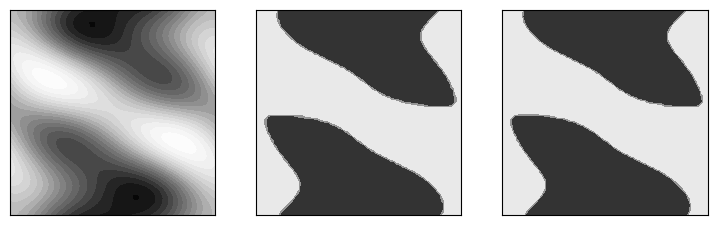

In [40]:
figure(figsize=(9,3))
subplot(1, 3, 1)
xticks([])
yticks([])
gca().set_aspect("equal")
contourf(xs, ys, epsilon_smooth, cmap="Greys", origin="lower", levels=20)
subplot(1, 3, 2)
gca().set_aspect("equal")
xticks([])
yticks([])
contourf(xs, ys, epsilon_two_tone, cmap="Greys", origin="lower", levels=2)
subplot(1, 3, 3)
contourf(xs, ys, round.(epsilon_high_contrast, digits=3), cmap="Greys", origin="lower", levels=2)
gca().set_aspect("equal")
xticks([])
yticks([]);
#savefig("./figures/inverse_design_dielectric_from_KAN.pdf")